<a id='top'></a>
# Explort Classification Models

<a href=#readdata>Read Data</a>  

<a href=#modelexploration>Model Exploration</a>

<a href=#logreg>Logistic Regression</a>

<a href=#balancedata>Balance Data</a>

<a href=#logistic_rebalance>Logistic Regression on Re-Balance Data</a>

<a href=#plot>Plot ROC Curve</a>

<a href=#bottom>Bottom</a>


In [8]:
# Ignore 'dask' warning

import pandas as pd
import gcsfs
from google.cloud import storage
from pandas import DataFrame
from IPython.display import HTML
from google.cloud.storage import Blob
import datalab.storage as gcs_datalab
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import preprocessing
from tpot import TPOTClassifier

from matplotlib import pyplot
import seaborn as sns
from scipy import stats

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


<a id='readdata'></a>

# Read in data from CSV file

<a href=#top>Top</a>

In [2]:
data_df = pd.read_csv('../Data_Merging/subset_2018.csv')

In [3]:
data_df.groupby('id_branch').id_branch.nunique().sum()

517834

In [4]:
data_df.columns

Index(['Unnamed: 0', 'date_month', 'id_company', 'id_branch',
       'is_discontinued', 'financial_calamity_outcome', 'qty_employees',
       'year_qty_employees', 'id_company_creditproxy',
       'score_payment_assessment', 'amt_revenue', 'year_revenue',
       'amt_consolidated_revenue', 'year_consolidated_revenue',
       'amt_consolidated_operating_result',
       'year_consolidated_operating_result', 'perc_credit_limit_adjustment',
       'color_credit_status', 'rat_pd', 'score_pd', 'has_increased_risk',
       'is_sole_proprietor', 'code_sbi_2', 'code_sbi_1',
       'qty_address_mutations_total', 'qty_address_mutations_month',
       'has_relocated', 'has_name_change', 'vice_president'],
      dtype='object')

In [5]:
data_df.has_relocated.value_counts()

False    1342874
True        5818
Name: has_relocated, dtype: int64

In [6]:
data_df.has_relocated.value_counts() / data_df.shape[0]

False    0.995686
True     0.004314
Name: has_relocated, dtype: float64

<a id='modelexploration'></a>
# Model Exploration
<a href=#top>Top</a>

In [ ]:
from tpot import TPOTClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data.astype(np.float64),
    iris.target.astype(np.float64), train_size=0.75, test_size=0.25)

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
#tpot.export('tpot_iris_pipeline.py')

In [7]:
feature_cols = ['score_pd', 'score_payment_assessment', 'code_sbi_2']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(data_df[feature_cols], data_df.has_relocated, 
                                                    test_size=0.75, random_state=0)


In [15]:
x_train.shape

(337173, 3)

In [ ]:
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
#tpot.export('tpot_iris_pipeline.py')

<a id='logreg'></a>
# Logistic Regression:

<a href=#top>Top</a>

In [6]:
feature_cols = ['score_pd', 'score_payment_assessment', 'code_sbi_2']

In [72]:
x_train, x_test, y_train, y_test = train_test_split(data_df[feature_cols], data_df.has_relocated, 
                                                    test_size=0.25, random_state=0)


In [147]:
logisticRegr0 = LogisticRegression()

In [148]:
logisticRegr0.fit(x_train, y_train)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [149]:
y_pred=logisticRegr0.predict(x_test)

In [150]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[335710,      0],
       [  1463,      0]])

In [152]:
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logisticRegr0.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.9957


In [153]:
y_test.value_counts() / y_test.shape[0]

False    0.995661
True     0.004339
Name: has_relocated, dtype: float64

In [154]:
roc=metrics.roc_auc_score(y_test, y_pred)
roc

0.5

In [171]:
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = logisticRegr0.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [160]:
score, auc, kappa

(0.9956609811580406, 0.6658057744114946, 0.0)

In [161]:
np.mean(y_probs)

0.004302105479977555

In [122]:
stats.describe(y_probs)

DescribeResult(nobs=337173, minmax=(0.0001174316986570109, 0.011594590759435497), mean=0.004302105479977555, variance=5.4590636362499024e-06, skewness=1.15917656096959, kurtosis=0.6849051508925967)

In [163]:
sum(y_pred)

0

In [172]:
print(cr)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    335710
        True       0.00      0.00      0.00      1463

   micro avg       1.00      1.00      1.00    337173
   macro avg       0.50      0.50      0.50    337173
weighted avg       0.99      1.00      0.99    337173



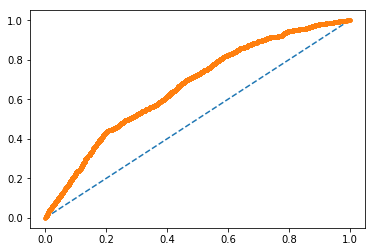

In [165]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='balancedata'></a>
## Balance Data:

<a href=#top>Top</a>

In [125]:
# Choose desired class breakdown
fraction_majority = 0.60

In [126]:
num_minority = data_df[data_df['has_relocated']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(5818, 8726, 8726.999999999998, 0.6)

In [127]:
# Separate majority and minority classes
df_majority = data_df[data_df.has_relocated==False]
df_minority = data_df[data_df.has_relocated==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated.value_counts()

False    8726
True     5818
Name: has_relocated, dtype: int64

In [128]:
df_downsampled.has_relocated.value_counts()/df_downsampled.shape[0]

False    0.599972
True     0.400028
Name: has_relocated, dtype: float64

<a id='logistic_rebalance'></a>

# Logistic Regression on Re-balanced data

<a href=#top>Top</a>

In [129]:
feature_cols = ['score_pd', 'score_payment_assessment', 'code_sbi_2']

In [130]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(df_downsampled[feature_cols], 
                                                                df_downsampled.has_relocated, 
                                                    test_size=0.25, random_state=0)


In [131]:
logisticRegr.fit(x_re_train, y_re_train)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [132]:
y_re_pred=logisticRegr.predict(x_re_test)

In [133]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[1770,  389],
       [ 887,  590]])

In [134]:
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logisticRegr.score(x_re_test, y_re_test)))

Accuracy of logistic regression classifier on test set: 0.6491


In [136]:
roc=metrics.roc_auc_score(y_re_test, y_re_pred)
roc

0.6096411770664156

In [168]:
score=metrics.accuracy_score(y_re_test, y_re_pred)

# Get probabilities
y_re_probs = logisticRegr.predict_proba(x_re_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

In [138]:
score, auc, kappa

(0.6490649064906491, 0.6536886576102994, 0.23161682993681731)

In [170]:
print(cr)

              precision    recall  f1-score   support

       False       0.67      0.82      0.74      2159
        True       0.60      0.40      0.48      1477

   micro avg       0.65      0.65      0.65      3636
   macro avg       0.63      0.61      0.61      3636
weighted avg       0.64      0.65      0.63      3636



<a id='plot'></a>
# Plot

<a href=#top>Top</a>


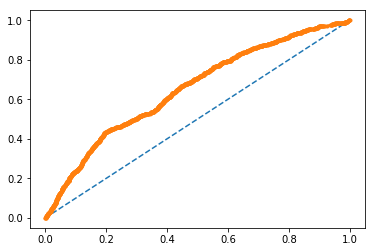

In [145]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

## Notes:

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [1]:
from tpot import TPOTClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

ImportError: No module named 'tpot'

In [4]:
import sys

In [5]:
sys.executable

'/home/mrodriguezlara/graydon/graydon-moving/bin/python3'

<a id='bottom'></a>

<a href=#top>Top</a>

# End